In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from sklearn.linear_model import LinearRegression
import yfinance as yf
import keras_tuner as kt
import pickle 

def create_linear_model_and_residuals():
    data= yf.download('SPY', period='10y', progress=False, auto_adjust=True)

    new_cols= []
    if isinstance(data.columns, pd.MultiIndex) or any(isinstance(c, tuple) for c in data.columns):
        new_cols= [col[0] if isinstance(col, tuple) else col for col in data.columns]
    else:
        new_cols= data.columns.tolist()
    new_cols= [str(col).replace(' ', '_').capitalize() for col in new_cols]
    data.columns = new_cols

    close_col= 'Close'
    volume_col= 'Volume' if 'Volume' in data.columns else None
    if close_col not in data.columns:
        raise ValueError("could not find 'Close' price column")


    features = pd.DataFrame(index=data.index)
    features['returns']= data[close_col].pct_change()
    # momentum features
    features['momentum_5d']= data[close_col].pct_change(5)
    features['momentum_21d']= data[close_col].pct_change(21)
    features['momentum_50d']= data[close_col].pct_change(50)
    features['momentum_200d']= data[close_col].pct_change(200)
    # volatility features
    features['volatility_5d']= features['returns'].rolling(5).std()
    features['volatility_21d']= features['returns'].rolling(21).std()
    features['volatility_50d']= features['returns'].rolling(50).std()
    features['volatility_200d']= features['returns'].rolling(200).std()
    # MA features
    ma_5 = data[close_col].rolling(5).mean()
    ma_21 = data[close_col].rolling(21).mean()
    ma_50 = data[close_col].rolling(50).mean()
    ma_200 = data[close_col].rolling(200).mean()
    features['MA_5_21_ratio']= ma_5 / ma_21
    features['MA_21_50_ratio'] = ma_21 / ma_50
    features['MA_50_200_ratio'] = ma_50 / ma_200
    # volume feature
    if volume_col:
        features['volume_ratio']= (data[volume_col] /
                                   data[volume_col].rolling(21).mean())
    # target
    features['target']= features['returns'].shift(-1)

    # drop NaNs
    features_clean= features.iloc[200:-1].copy()

    # split
    split_idx= int(0.7 * len(features_clean))
    train= features_clean.iloc[:split_idx]
    test= features_clean.iloc[split_idx:]

    # define feature columns for LR
    feature_cols= [
        'momentum_5d', 'momentum_21d', 'momentum_50d', 'momentum_200d',
        'volatility_5d', 'volatility_21d', 'volatility_50d', 'volatility_200d',
        'MA_5_21_ratio', 'MA_21_50_ratio', 'MA_50_200_ratio',
    ]
    if 'volume_ratio' in features_clean.columns:
         feature_cols.append('volume_ratio')

    X_train, X_test= train[feature_cols], test[feature_cols]
    y_train, y_test= train['target'], test['target']

    # train linear model
    lr_model= LinearRegression()
    lr_model.fit(X_train, y_train)

    # get predictions and residuals
    train_pred= lr_model.predict(X_train)
    test_pred= lr_model.predict(X_test)
    train_residuals= pd.Series(y_train - train_pred, index=y_train.index)
    test_residuals= pd.Series(y_test - test_pred, index=y_test.index)

    return train_residuals, test_residuals, y_test, test_pred, lr_model, feature_cols

# get the residuals and other data from linear model
train_residuals, test_residuals, y_test, linear_test_pred, lr_model, lr_feature_cols= create_linear_model_and_residuals()

print(f"training residuals: {len(train_residuals)} samples")
print(f"test residuals: {len(test_residuals)} samples")
print(f"test actual values: {len(y_test)} samples")
print(f"linear test predictions: {len(linear_test_pred)} samples")

training residuals: 1619 samples
test residuals: 695 samples
test actual values: 695 samples
linear test predictions: 695 samples


In [9]:
scaler = StandardScaler()

# Fit scaler only on training residuals and transform both
# Reshape residuals to 2D array for scaler
train_residuals_scaled= scaler.fit_transform(train_residuals.values.reshape(-1, 1))
test_residuals_scaled= scaler.transform(test_residuals.values.reshape(-1, 1))

print(f"\nresiduals scaled using StandardScaler.")
print(f"scaled train residuals shape: {train_residuals_scaled.shape}")
print(f"scaled test residuals shape: {test_residuals_scaled.shape}")



residuals scaled using StandardScaler.
scaled train residuals shape: (1619, 1)
scaled test residuals shape: (695, 1)


In [10]:
def create_sequences(data, sequence_length=10):
    sequences= []
    targets= []
    for i in range(len(data) - sequence_length):
        seq= data[i:i + sequence_length]
        target= data[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets).reshape(-1, 1)

sequence_length= 10
X_seq_train, y_seq_train= create_sequences(train_residuals_scaled, sequence_length)
X_seq_test, y_seq_test= create_sequences(test_residuals_scaled, sequence_length)

print(f"\ncreated sequences from scaled residuals:")
print(f"training sequences X: {X_seq_train.shape}, y: {y_seq_train.shape}")
print(f"test sequences X: {X_seq_test.shape}, y: {y_seq_test.shape}")

print(f"final shape - train X: {X_seq_train.shape}, test X: {X_seq_test.shape}")


created sequences from scaled residuals:
training sequences X: (1609, 10, 1), y: (1609, 1)
test sequences X: (685, 10, 1), y: (685, 1)
final shape - train X: (1609, 10, 1), test X: (685, 10, 1)


In [11]:
# build and train LSTM model
def build_lstm_model(sequence_length, units=50):
    model= tf.keras.Sequential([
        tf.keras.layers.LSTM(units, input_shape=(sequence_length, 1)),
        tf.keras.layers.Dropout(0.2),  # prevent overfitting
        tf.keras.layers.Dense(25, activation='relu'),
        tf.keras.layers.Dense(1)  # predict residual value
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return model

# build model
lstm_model= build_lstm_model(sequence_length)
print("LSTM model summary:")
lstm_model.summary()

LSTM model summary:


c:\Users\Johnny\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,701 (45.71 KB)

 Trainable params: 11,701 (45.71 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# LSTM hypermarameter tuning

def build_tuned_lstm_model(hp):
    model= keras.Sequential()

    # tune LSTM units
    hp_units_lstm= hp.Int('units_lstm', min_value=20, max_value=100, step=10)
    model.add(keras.layers.LSTM(units=hp_units_lstm, input_shape=(sequence_length, 1)))

    # tune Dropout rate
    hp_dropout= hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(rate=hp_dropout))

    # tune Dense units
    hp_units_dense= hp.Int('units_dense', min_value=10, max_value=50, step=10)
    model.add(keras.layers.Dense(units=hp_units_dense, activation='relu'))

    model.add(keras.layers.Dense(1))

    # tune learning rate
    hp_learning_rate= hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mse',
        metrics=['mae']
    )
    return model

tuner = kt.RandomSearch(
    build_tuned_lstm_model,
    objective='val_loss',
    max_trials=10, # Number of hyperparameter combinations to try
    executions_per_trial=1, # Can increase for stability, but slower
    directory='keras_tuner_dir',
    project_name='lstm_residuals_tuning'
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\n--- Starting Hyperparameter Search ---")
# run the hyperparameter search
# use a smaller subset for faster tuning, use full data for final model

tuner_split = int(0.8 * len(X_seq_train))
X_tuner_train, X_tuner_val= X_seq_train[:tuner_split], X_seq_train[tuner_split:]
y_tuner_train, y_tuner_val= y_seq_train[:tuner_split], y_seq_train[tuner_split:]

tuner.search(X_tuner_train, y_tuner_train,
             epochs=30, 
             validation_data=(X_tuner_val, y_tuner_val),
             callbacks=[early_stopping],
             verbose=1)

# get the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n--- Best Hyperparameters Found ---")
print(f"LSTM units: {best_hps.get('units_lstm')}")
print(f"dropout rate: {best_hps.get('dropout'):.2f}")
print(f"dense units: {best_hps.get('units_dense')}")
print(f"learning rate: {best_hps.get('learning_rate')}")

# retrieve the best model directly
best_lstm_model= tuner.get_best_models(num_models=1)[0]




# Evaluate the best model on the test data
loss, mae = best_lstm_model.evaluate(X_seq_test, y_seq_test, verbose=0)
print(f"\nbest tuned LSTM model test performance:")
print(f"  test loss (MSE): {loss:.6f}")
print(f"  Test MAE: {mae:.6f}")

best_lstm_model.summary()

Reloading Tuner from keras_tuner_dir\lstm_residuals_tuning\tuner0.json



--- Starting Hyperparameter Search ---

--- Best Hyperparameters Found ---
LSTM units: 60
dropout rate: 0.50
dense units: 40
learning rate: 0.01


c:\Users\Johnny\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



best tuned LSTM model test performance:
  test loss (MSE): 0.652201
  Test MAE: 0.552322


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60)             │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,361 (67.82 KB)

 Trainable params: 17,361 (67.82 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
lstm_test_pred_scaled= best_lstm_model.predict(X_seq_test).flatten()

lstm_test_pred= scaler.inverse_transform(lstm_test_pred_scaled.reshape(-1, 1)).flatten()

print("\nshape check after inverse transform:")
print(f"LSTM test pred (original scale): {lstm_test_pred.shape}")
print(f"linear test pred: {linear_test_pred.shape}")
print(f"test actuals (y_test): {y_test.shape}")

# align predictions
test_start_idx= sequence_length
linear_test_pred_np= np.array(linear_test_pred)
combined_test_pred= linear_test_pred_np[test_start_idx:] + lstm_test_pred
# align actual values
y_actual_aligned= y_test.iloc[test_start_idx:]

print(f"\nafter alignment:")
print(f"combined test pred: {len(combined_test_pred)}")
print(f"actual values aligned: {len(y_actual_aligned)}")
print(f"linear pred aligned: {len(linear_test_pred_np[test_start_idx:])}")

# evaluate models 
def evaluate_model(actual, predictions, name):
    actual_np= np.array(actual)
    predictions_np= np.array(predictions)

    if len(actual_np)!= len(predictions_np):
         raise ValueError(f"length mismatch: actual ({len(actual_np)}) vs predictions ({len(predictions_np)})")
    if len(actual_np)== 0:
        print(f"Warning: No data to evaluate for {name}")
        return np.nan, np.nan, np.nan, np.nan

    mse= mean_squared_error(actual_np, predictions_np)
    mae= mean_absolute_error(actual_np, predictions_np)
    direction_accuracy= np.mean(np.sign(actual_np)== np.sign(predictions_np)) 

    direction_accuracy_non_zero= np.mean(np.sign(actual_np[actual_np!= 0])== np.sign(predictions_np[actual_np != 0]))

    correlation= np.corrcoef(actual_np, predictions_np)[0,1] if len(actual_np) > 1 else np.nan

    print(f"\n{name}:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  direction accuracy: {direction_accuracy:.2%}")
    print(f"  direction accuracy: {direction_accuracy_non_zero:.2%}")
    print(f"  correlation: {correlation:.4f}")
    return mse, mae, direction_accuracy_non_zero, correlation

# evaluate aligned linear model and combined model
print("\n--- MODEL COMPARISON ---")
linear_mse, linear_mae, linear_acc, linear_corr = evaluate_model(y_actual_aligned, linear_test_pred_np[test_start_idx:], "Linear Model (Aligned)")
combined_mse, combined_mae, combined_acc, combined_corr = evaluate_model(y_actual_aligned, combined_test_pred, "Combined Model (LR + Tuned LSTM)")

# simple cost adjustment function
def adjusted_direction_accuracy(actual, predicted, cost_threshold=0.001):
    actual_np = np.array(actual)
    predicted_np = np.array(predicted)
    profitable_trades = ((np.sign(actual_np) == np.sign(predicted_np)) & (np.abs(predicted_np) > cost_threshold)).sum()
    total_trades = (np.abs(predicted_np) > cost_threshold).sum()
    return profitable_trades / total_trades if total_trades > 0 else 0

adjusted_acc = adjusted_direction_accuracy(y_actual_aligned, combined_test_pred)
print(f"\ncost-adjusted accuracy (combined model): {adjusted_acc:.2%}")

improvement = combined_acc - linear_acc


if improvement > 0.001: # Check for meaningful improvement
    print("LSTM successfully improved the model's directional accuracy.")
elif improvement > -0.001:
     print("tuned LSTM did not significantly change directional accuracy.")
else:
    print("tuned LSTM slightly worsened directional accuracy.")



22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

shape check after inverse transform:
LSTM test pred (original scale): (685,)
linear test pred: (695,)
test actuals (y_test): (695,)

after alignment:
combined test pred: 685
actual values aligned: 685
linear pred aligned: 685

--- MODEL COMPARISON ---

Linear Model (Aligned):
  MSE: 0.000094
  MAE: 0.006627
  direction accuracy: 52.70%
  direction accuracy: 52.78%
  correlation: 0.1347

Combined Model (LR + Tuned LSTM):
  MSE: 0.000094
  MAE: 0.006642
  direction accuracy: 51.09%
  direction accuracy: 51.17%
  correlation: 0.1380

cost-adjusted accuracy (combined model): 52.03%
tuned LSTM slightly worsened directional accuracy.


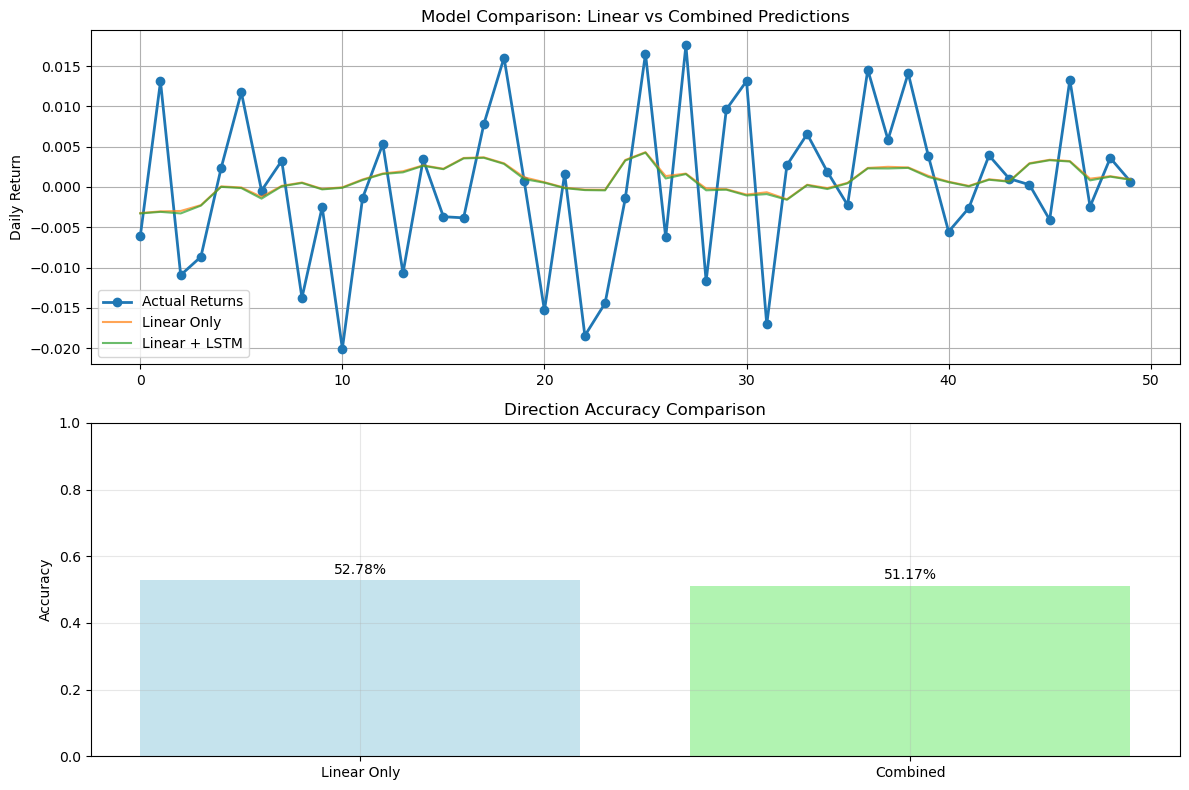


--- PROJECT SUMMARY ---
combined model direction accuracy: 51.17%
improvement over linear model: -1.61%

linear model feature importance

            feature  coefficient  abs_importance
0     volatility_5d    -0.444012        0.444012
1   volatility_200d     0.242839        0.242839
2    volatility_21d     0.169429        0.169429
3     MA_5_21_ratio    -0.072966        0.072966
4    MA_21_50_ratio    -0.050615        0.050615
5    volatility_50d     0.049474        0.049474
6       momentum_5d    -0.043232        0.043232
7   MA_50_200_ratio    -0.017266        0.017266
8     momentum_200d     0.009392        0.009392
9      momentum_21d     0.008430        0.008430
10     momentum_50d    -0.004377        0.004377
11     volume_ratio     0.000113        0.000113


In [14]:
# plot comparison of all models
plt.figure(figsize=(12, 8))

# actual vs predictions
plt.subplot(2, 1, 1)
points_to_plot = min(50, len(y_actual_aligned))
x_axis = range(points_to_plot)

plt.plot(x_axis, y_actual_aligned.values[:points_to_plot], 
         label='Actual Returns', marker='o', linewidth=2)
plt.plot(x_axis, linear_test_pred[test_start_idx:test_start_idx + points_to_plot], 
         label='Linear Only', alpha=0.7)
plt.plot(x_axis, combined_test_pred[:points_to_plot], 
         label='Linear + LSTM', alpha=0.7)

plt.title('Model Comparison: Linear vs Combined Predictions')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)

# direction accuracy comparison
plt.subplot(2, 1, 2)
models= ['Linear Only', 'Combined']
accuracy= [linear_acc, combined_acc]

bars= plt.bar(models, accuracy, color=['lightblue', 'lightgreen'], alpha=0.7)
plt.title('Direction Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# add value labels on bars
for bar, acc in zip(bars, accuracy):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.2%}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n--- PROJECT SUMMARY ---")
print(f"combined model direction accuracy: {combined_acc:.2%}")
print(f"improvement over linear model: {improvement:+.2%}")

# display linear model feature importance 
if 'lr_model' in locals() and 'lr_feature_cols' in locals():
    feature_importance = pd.DataFrame({
        'feature': lr_feature_cols,
        'coefficient': lr_model.coef_,
        'abs_importance': np.abs(lr_model.coef_)
    }).sort_values('abs_importance', ascending=False).reset_index(drop=True)
    # --- ---

    print("\nlinear model feature importance\n")
    print(feature_importance)
